# Imports

In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
from interface_pde import BasePDE

from utils_uq_vi import VIBPINN
from utils_pde_damposcillation import DampedOscillator1D
from utils_pde_poisson import Poisson1D
from utils_result_viz import * # plot_truth_and_samples_1D, plot_training_history

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


# 1D Poisson Equation



$$\frac{d^2 u}{dx^2} = f(x), \quad x \in (0, 1) \text{ with boundary conditions: $u(0)=0$ and $u(1)=1$}$$

The analytical solution: $u^*(x) = \sin(\pi x)$  
  
The source function: $f(x) = -\pi^2 \sin(\pi x)$

For simplicity of this problem, we denote the input as X and output as Y

## Define PDE & Simulate noisy data

In [2]:
# Analytical solution
u_star = lambda x: np.sin(math.pi * x)


# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return -(math.pi**2) * torch.sin(math.pi * x)

In [3]:
data_noise = 0.05

# Instantiate Poisson PDE problem
pde = Poisson1D(f_func=f_func, 
                bc_values=(torch.tensor([[0.0]]), torch.tensor([[0.0]])),
                domain=(0,1), true_solution=u_star)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)
# Collocation points in (0,1)
x_colloc_num = 250
x_collocation = torch.linspace(0.0, 1.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 1)].view(-1, 1)

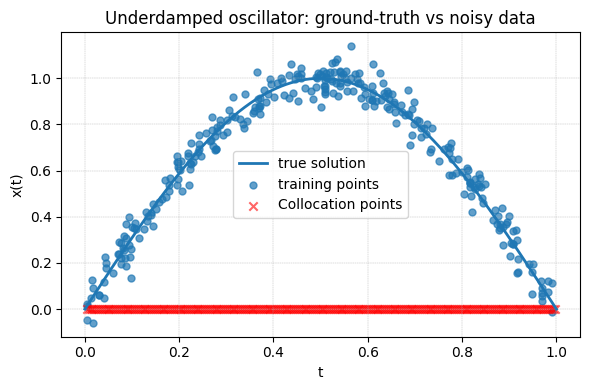

In [4]:
fig, ax = plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 1,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=u_star,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

**Parameters for tuning prediction spread:**

- `rho`: define the Bayesian Layer parameters' spread
  
- `piror_std`: define the piror distribution's std
- `data_noise_guess`: define the guessed data noise in the loss function - negative log likelihood

In [5]:
from draft import VIBPINN

vi_poisson_model = VIBPINN(pde, 1, [16, 32, 32, 16], 1, mu_std = 0.01, rho = -3.0, prior_std=1.0)
loss_dict = vi_poisson_model.fit_vi_bpinn(x_colloc_num, X_train, Y_train, epochs=10000, lr=3e-3,
                               λ_pde=1.0,λ_ic=0.0,λ_bc=1.0, λ_elbo=1.0)

ep     0 | L=2.44e+03 | elbo=8.38e+01 | pde=2.35e+03  ic=0.00e+00  bc=1.46e-03 | lr=3.00e-03
ep     1 | L=2.44e+03 | elbo=8.87e+01 | pde=2.35e+03  ic=0.00e+00  bc=8.44e-05 | lr=3.00e-03
ep   100 | L=2.99e+02 | elbo=1.05e+02 | pde=1.90e+02  ic=0.00e+00  bc=4.86e+00 | lr=3.00e-03
ep   200 | L=1.59e+02 | elbo=5.82e+01 | pde=9.78e+01  ic=0.00e+00  bc=3.15e+00 | lr=3.00e-03
ep   300 | L=2.18e+02 | elbo=1.26e+02 | pde=8.97e+01  ic=0.00e+00  bc=3.02e+00 | lr=3.00e-03
ep   400 | L=2.43e+01 | elbo=1.94e+01 | pde=3.88e+00  ic=0.00e+00  bc=1.04e+00 | lr=3.00e-03
ep   500 | L=3.33e+01 | elbo=1.68e+01 | pde=1.60e+01  ic=0.00e+00  bc=5.41e-01 | lr=3.00e-03
ep   600 | L=5.21e+01 | elbo=1.85e+01 | pde=3.35e+01  ic=0.00e+00  bc=8.66e-02 | lr=3.00e-03
ep   700 | L=3.90e+01 | elbo=2.89e+01 | pde=9.80e+00  ic=0.00e+00  bc=3.31e-01 | lr=3.00e-03
ep   800 | L=3.51e+01 | elbo=1.47e+01 | pde=2.00e+01  ic=0.00e+00  bc=3.78e-01 | lr=3.00e-03
ep   900 | L=1.09e+02 | elbo=1.11e+01 | pde=9.74e+01  ic=0.00e+00  bc=

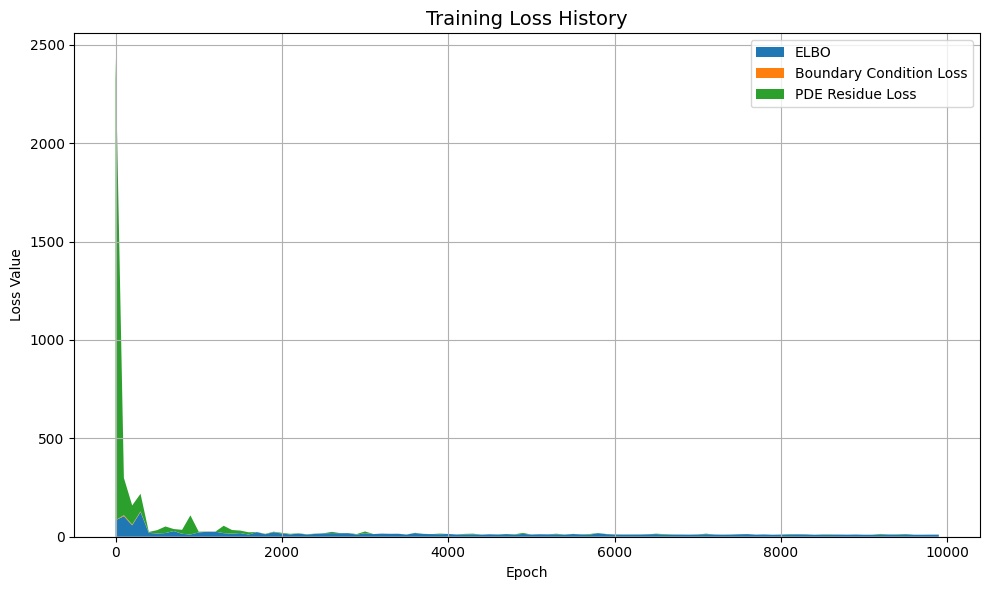

In [6]:
plot_training_history(loss_dict, plot_after=0, step=100)

In [ ]:
x_grid = torch.linspace(0, 1, 100).view(-1, 1)
mean, pred_set = vi_poisson_model.predict(X_test, n_samples=1000)

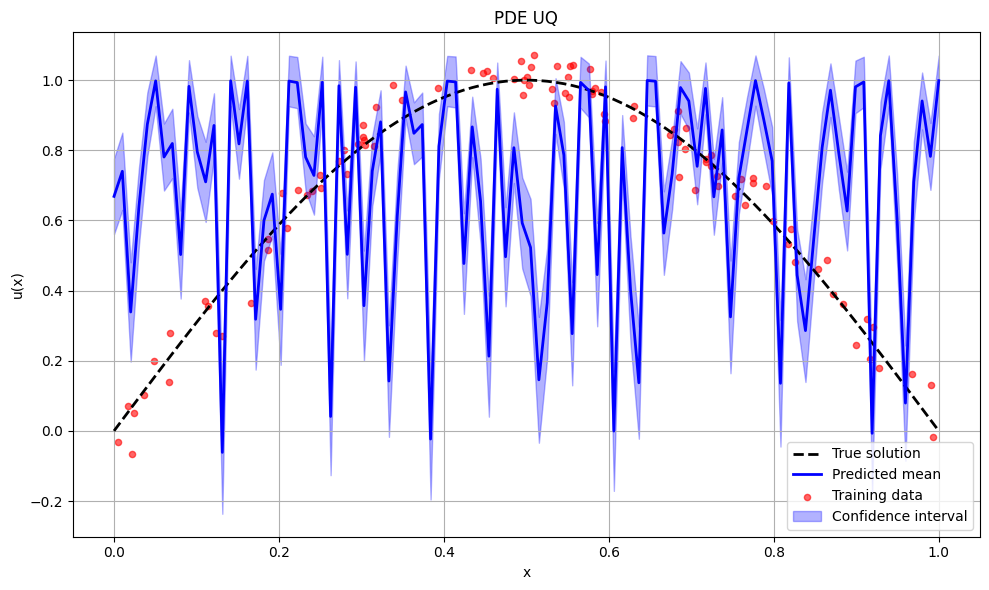

In [8]:
plot_predictions_1D(x_grid, pred_set, u_star, X=X_test, Y=Y_test)

## Sharpness & Coverage 

In [9]:
test_uncertainties(vi_poisson_model, [])

NameError: name 'test_uncertainties' is not defined

### Sharpness

### Coverage

In [ ]:

def plot_predictions_1D(x_grid, pred_set, true_solution, title="PDE UQ",
                        X=None, Y=None):
    """
    Plots the true solution, predicted bounds (from pred_set), and training data.

    Args:
        x_grid: 1D tensor of test inputs
        pred_set: list of [lower_bound, upper_bound] tensors
        true_solution: function that returns the true u(x)
        title: plot title
        X, Y: optional training data for scatter plot
    """
    x_grid_np = x_grid.detach().cpu().numpy().flatten()
    lower_np = pred_set[0].detach().cpu().numpy().flatten()
    upper_np = pred_set[1].detach().cpu().numpy().flatten()
    mean_np = (lower_np + upper_np) / 2.0

    y_true = true_solution(x_grid_np)

    plt.figure(figsize=(10, 6))
    plt.plot(x_grid_np, y_true, 'k--', label="True solution", linewidth=2)
    plt.plot(x_grid_np, mean_np, 'b-', label="Predicted mean", linewidth=2)
    if X is not None and Y is not None:
        plt.scatter(X.detach().cpu().numpy().flatten(), Y.detach().cpu().numpy().flatten(),
                    c='red', s=20, label="Training data", alpha=0.6)
    plt.fill_between(x_grid_np, lower_np, upper_np, color='blue', alpha=0.3, label="Confidence interval")

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x_grid, mean, 'k--', label="True solution", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'mean' is not defined

<Figure size 1000x600 with 0 Axes>